# Notebook setup: modules and functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import xarray as xr
from netCDF4 import Dataset # Because we will change the netCDF files on disk in some cases
import numpy as np                
import os, subprocess, glob
from shutil import copy2
# Remove old files
for f in glob.glob(os.path.join("data/", "coefficients*.nc")): os.remove(f)
for f in glob.glob(os.path.join("data/", "rrtmgp*.nc")): os.remove(f)
#
# To do: 
# Enforce the same y-axis limits within sets of figures
# re-do vertical profiles: remove top level/layer, separate into tropo/strato
# since we're going to show tuned and untuned in all figs maybe go back to G -> untuned -> GP ordering

# User directory configuration 

In [2]:
# Location of RTE+RRTMGP distribution directory
# Default is ~/Codes/rte-rrtmgp 
rte_rrtmgp_dir  = os.path.expanduser("~") + "/Codes/rte-rrtmgp/"

# Location of testing/validation directory, used to obtain un-tuned absorption coefficients 
# Default is ~/Codes/RRTMGP/trunk/
rrtmgp_test_dir = os.path.expanduser("~") + "/Codes/RRTMGP/trunk/"

In [3]:
p_tropo = 10000  # Tropopause is 100 hPa

# https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')   

def copyVar(nc_in, nc_out, name) :
    nc_out.createVariable(name, nc_in.variables[name].dtype, nc_in.variables[name].dimensions)
    nc_out.variables[name].setncatts(nc_in.variables[name].__dict__)
    nc_out.variables[name][:] = nc_in.variables[name][:]

def level_index(location, data, pressure = "p_lev"): 
    #
    # Find the integer value of lev that corresponds to desired pressure = (max(p) for 'sfc', closest value to 100 hPa for 'tropo', min(p) for 'toa')
    #   For the Garand files we assume that pressures are the same for all columns
    #
    # argument location is text; data is xarray dataset 
    #
    sfc = data.isel(col=0).variables[pressure].argmax()
    toa = data.isel(col=0).variables[pressure].argmin()
    tropo = np.abs(data.isel(col=0).variables[pressure][:] - p_tropo).argmin()
    locs = {'sf':sfc, 'su':sfc, 'to':toa, 'tr':tropo}
    return(locs.get(location[:2].lower(), -1))
    
def compute_error_range(location, quantity, ref_file, test_files):
    # location and quantity are text strings 
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]

    i = level_index(location,ref_file)
    ref = ref_ds.isel(lev=i).variables[quantity]
    errs = [tf.isel(lev=i).variables[quantity] - ref for tf in tst_ds]
    ref_ds.close()
    [tf.close() for tf in tst_ds]
    return(errs.minval(), errs.maxval())

def plot_err_distribution(axes, errs, test_labels, ylabel = "Error", colors = None):
    if colors == None: 
        sb.boxplot(data = errs)
    else:
        default = sb.color_palette(palette = None)
        sb.boxplot(data = errs, palette = sb.color_palette([default[c] for c in colors]))
        
    sb.swarmplot(data = errs, color = "0.25")
    axes.set_ylabel(ylabel)
    axes.set_xticklabels(test_labels)
    axes.axhline()

In [4]:
fig_size = 95 

# Data from external calculations

In [5]:
#
# Results from LBLRTM and RRTMG 
#
lw_lblrtm_file = 'data/lblrtm-v12.8-lw-flux-inputs-outputs-garand-r1378.nc'
lw_rrtmg_file  = "data/" + "rrtmg-lw-inputs-outputs_alb_0.2_sza_30.nc"
sw_charts_file = 'data/charts-sw-inputs-outputs-clear_alb0_sza30.nc'
sw_rrtmg_file  = "data/" + "rrtmg-sw-inputs-outputs_alb_0.0_sza_30.nc"
#
# Location of surface, top-of-atmosphere
#
lw_lblrtm = xr.open_dataset(lw_lblrtm_file)
toa = (lw_lblrtm.variables['p_lev'][:]).argmin(dim="lev")
sfc = (lw_lblrtm.variables['p_lev'][:]).argmax(dim="lev")
lw_lblrtm.close()
#
# heating rates in RRTMG files are in K/d; modify to K/s
# net flux is negative in SW file
#
copy2(lw_rrtmg_file, "data/" + "rrtmg-lw-inputs-outputs.nc")
lw_rrtmg_file = "data/" + "rrtmg-lw-inputs-outputs.nc"
copy2(sw_rrtmg_file, "data/" + "rrtmg-sw-inputs-outputs.nc")
sw_rrtmg_file = "data/" + "rrtmg-sw-inputs-outputs.nc"
for f in [sw_rrtmg_file, lw_rrtmg_file]: 
    x = Dataset(f, 'a')
    x.variables["heating_rate"][:] = x.variables["heating_rate"][:]/86400.
    x.close()
for f in [sw_rrtmg_file]: 
    x = Dataset(f, 'a')
    x.variables["flux_net"][:] = -x.variables["flux_net"][:]
    x.close()


# RRTMGP calculations

In [6]:
#
# Set up the ability to calculate fluxes with RRTMGP
#   Build the RTE+RRMTGP library
#   This relies on users have set up a Makefile.conf in rte_rrtmgp_dir + "build/" or 
#   having defined variables FC and FCFLAGS in the environment 
#
subprocess.run(["export RRTMGP_ROOT=" + rte_rrtmgp_dir + "; " + \
                "cd " + rte_rrtmgp_dir + "build/; make "], shell=True)
#
# Build the program that computes fluxes from netCDF Garand atmosphere files
#   Users will need to have edited "Makefile" to point to netCDF include files and 
#   C and Fortran libraries 
# 
subprocess.run(["export RRTMGP_ROOT=" + rte_rrtmgp_dir + "; make "], shell=True)
flux_exe_name   = "rrtmgp_garand_atmos"

#
# Coefficient files, executable for Garand atmospheres
#
copy2(rte_rrtmgp_dir + "rrtmgp/data/coefficients_lw.nc", "data/")
copy2(rte_rrtmgp_dir + "rrtmgp/data/coefficients_sw.nc", "data/")
copy2(rrtmgp_test_dir + "data/coefficients_lw_noscaling.nc", "data")
copy2(rrtmgp_test_dir + "data/coefficients_sw_noscaling.nc", "data/")

'data/coefficients_sw_noscaling.nc'

In [7]:
#
# RRTMGP calculations 
#

#
# Compute RRTMGP LW and SW solution
#
sw_rrtmgp_default_file = "data/" + "rrtmgp-sw-inputs-outputs-default.nc"
sw_rrtmgp_untuned_file = "data/" + "rrtmgp-sw-inputs-outputs-untuned.nc"
lw_rrtmgp_default_file = "data/" + "rrtmgp-lw-inputs-outputs-default.nc"
lw_rrtmgp_untuned_file = "data/" + "rrtmgp-lw-inputs-outputs-untuned.nc"

copy2(sw_charts_file, sw_rrtmgp_default_file)
copy2(sw_charts_file, sw_rrtmgp_untuned_file)
copy2(lw_lblrtm_file, lw_rrtmgp_default_file)
copy2(lw_lblrtm_file, lw_rrtmgp_untuned_file)

# Compute three-angle solutions - use the LBLRTM setup but remove the 
#   angle dimension and any variables that use it, then create a new
#   angle dimension of length 3 (this is how the RRTMGP driver knows 
#   how many quadrature angles to use)
#

lw_rrtmgp_3ang_default_file = "data/" + "rrtmgp-lw-inputs-outputs-3angle-default.nc"
lw_rrtmgp_3ang_untuned_file = "data/" + "rrtmgp-lw-inputs-outputs-3angle-untuned.nc"

varsToDel = ['angle', 'angle_secant', 'angle_weight']
dimsToDel = ['angle']

for fn in [lw_rrtmgp_3ang_default_file, lw_rrtmgp_3ang_untuned_file]:
  f    = Dataset(fn, 'w')
  oldF = Dataset(lw_lblrtm_file)  
  for d in oldF.dimensions: 
    if not d in dimsToDel: f.createDimension(oldF.dimensions[d].name, oldF.dimensions[d].size)
  for v in oldF.variables:  
    if not v in varsToDel: copyVar(oldF, f, v)
  oldF.close()
  f.createDimension("angle", 3)
  f.close()

subprocess.run(["./" + flux_exe_name, sw_rrtmgp_default_file, "data/coefficients_sw.nc"])
subprocess.run(["./" + flux_exe_name, sw_rrtmgp_untuned_file, "data/coefficients_sw_noscaling.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_3ang_default_file, "data/coefficients_lw.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_3ang_untuned_file, "data/coefficients_lw_noscaling.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_default_file, "data/coefficients_lw.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_untuned_file, "data/coefficients_lw_noscaling.nc"])

CompletedProcess(args=['./rrtmgp_garand_atmos', 'data/rrtmgp-lw-inputs-outputs-untuned.nc', 'data/coefficients_lw_noscaling.nc'], returncode=0)

# Assessing the k-distribution

In [8]:
def plot_single_level_errs(fig, axes, location, quantity, ref_file, test_files, test_labels, colors = None):
    """Plot the difference in 'quantity' at 'location' between a reference and one or more tests"""
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]

    i = level_index(location, ref_ds)
    ref = ref_ds.isel(lev=i).variables[quantity]
    errs = [tf.isel(lev=i).variables[quantity] - ref for tf in tst_ds]
    ref_ds.close()
    [tf.close() for tf in tst_ds]
    
    plot_err_distribution(axes, errs, test_labels, ylabel = "Error (W/m2)", colors = colors)

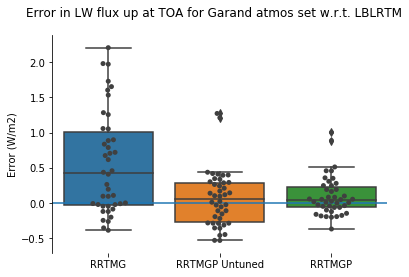

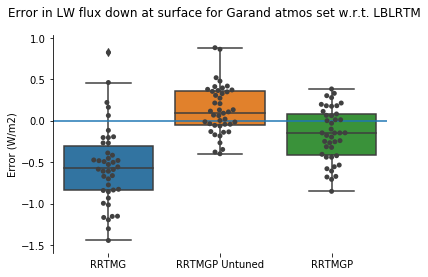

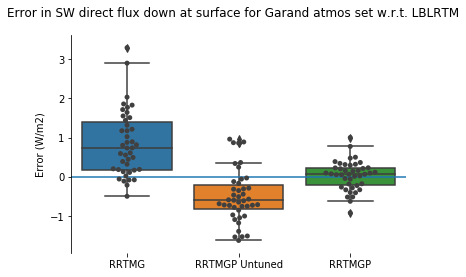

In [9]:
#
# Assessing the k-distribution: 
#  LW: three-angle solutions at TOA and SFC
#  use RRMTG too because tuned diffusivity angle 
#
fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "toa", "flux_up", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_3ang_untuned_file, lw_rrtmgp_3ang_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in LW flux up at TOA for Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-toa-kdist-tuning.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "sfc", "flux_dn", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_3ang_untuned_file, lw_rrtmgp_3ang_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])
fig.suptitle("Error in LW flux down at surface for Garand atmos set w.r.t. LBLRTM")
sb.despine()
axes.spines["bottom"].set_visible(False)
plt.savefig("lw-sfc-kdist-tuning.pdf", dpi=600)


#
#  SW: direct beam at SFC
#    do this for tuned and untuned coefficient files 
#  use RRMTG too
#
fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "sfc", "flux_dir_dn", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_untuned_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])

sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in SW direct flux down at surface for Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-sfc-kdist-tuning.pdf", dpi=600)

# Flux errors

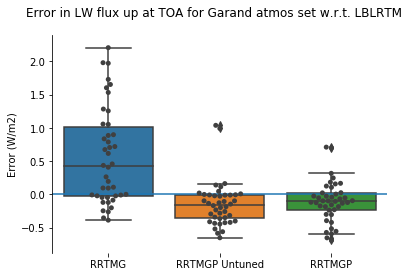

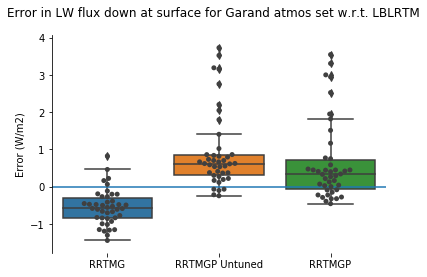

In [10]:
fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "toa", "flux_up", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_untuned_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in LW flux up at TOA for Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-toa-total-error.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "sfc", "flux_dn", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_untuned_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in LW flux down at surface for Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-sfc-total-error.pdf", dpi=600)

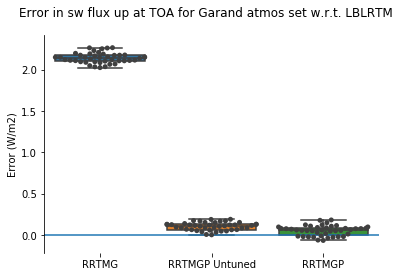

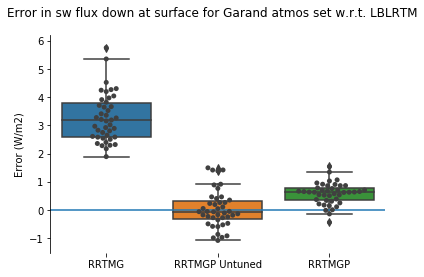

In [11]:
fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "toa", "flux_up", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_untuned_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in sw flux up at TOA for Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-toa-total-error.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "sfc", "flux_dn", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_untuned_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in sw flux down at surface for Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-sfc-total-error.pdf", dpi=600)

# Flux errors (no untuned results)

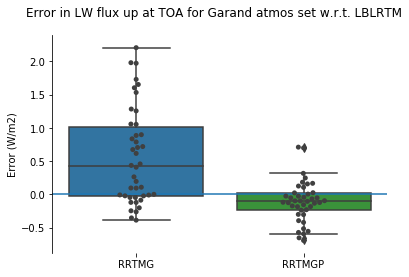

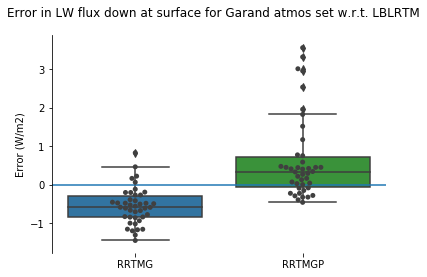

In [12]:
fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "toa", "flux_up", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0,2])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in LW flux up at TOA for Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-toa-total-error.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "sfc", "flux_dn", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0,2])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in LW flux down at surface for Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-sfc-total-error.pdf", dpi=600)

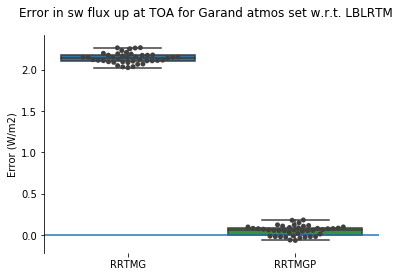

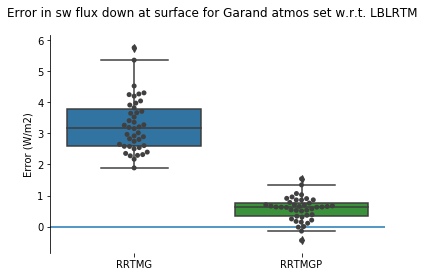

In [13]:
fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "toa", "flux_up", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0,2])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in sw flux up at TOA for Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-toa-total-error.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_single_level_errs(fig, axes, "sfc", "flux_dn", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0,2])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("Error in sw flux down at surface for Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-sfc-total-error.pdf", dpi=600)

In [14]:
#
# We could use this to enforce the same limits on plots 
#
def compute_error_range(location, quantity, ref_file, test_files):
    # location and quantity are text strings 
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]

    i = level_index(location,ref_ds)
    ref = ref_ds.isel(lev=i).variables[quantity]
    errs = [tf.isel(lev=i).variables[quantity] - ref for tf in tst_ds]
    ref_ds.close()
    [tf.close() for tf in tst_ds]
    return(np.min(errs), np.max(errs))

In [15]:
def extract_max_abs_err_in_vert(errs, vaxis='lev'):
    max_pos = errs.max(dim=vaxis)
    max_neg = errs.min(dim=vaxis)
    return(max_pos.where(max_pos > -max_neg, max_neg))

def plot_max_vert_err_distribution(axes, quantity, ref_file, test_files, test_labels, factor=1., yaxisunits="W/m2", colors = None):
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]
    vaxis = "lay" if "lay" in ref_ds.variables[quantity].dims else "lev"
    
    ref = ref_ds.variables[quantity][:]
    
    toa = level_index('toa',   ref_ds, "p_" + vaxis).values
    sfc = level_index('sfc',   ref_ds, "p_" + vaxis).values
    trp = level_index('tropo', ref_ds, "p_" + vaxis).values
    if vaxis == 'lev':
        # Lower atmosphere - we are assuming arrays are ordered from bottom to top in using slice() 
        errs =                       [extract_max_abs_err_in_vert((tf.variables[quantity][:] - ref).isel(lev=slice(sfc,trp-1)),vaxis)*factor for tf in tst_ds]
        # Upper atmosphere - neglect top layer/level
        # If we use a list comprehension here the last element is a "generator object" and not the data we want
        for tf in tst_ds: errs.append(extract_max_abs_err_in_vert((tf.variables[quantity][:] - ref).isel(lev=slice(trp,toa-1)),vaxis)*factor)
    else:
        # Lower atmosphere - we are assuming arrays are ordered from bottom to top in using slice() 
        errs =                       [extract_max_abs_err_in_vert((tf.variables[quantity][:] - ref).isel(lay=slice(sfc,trp-1)),vaxis)*factor for tf in tst_ds]
        # Upper atmosphere - neglect top layer/level
        # If we use a list comprehension here the last element is a "generator object" and not the data we want
        for tf in tst_ds: errs.append(extract_max_abs_err_in_vert((tf.variables[quantity][:] - ref).isel(lay=slice(trp,toa-1)),vaxis)*factor)

        
    labs = [t + " " + l for l in ["trop", "strat"] for t in test_labels]   
    plot_err_distribution(axes, errs, labs, ylabel = "Max error (" +  yaxisunits +")", colors = colors)

    [tf.close() for tf in tst_ds]
    ref_ds.close()

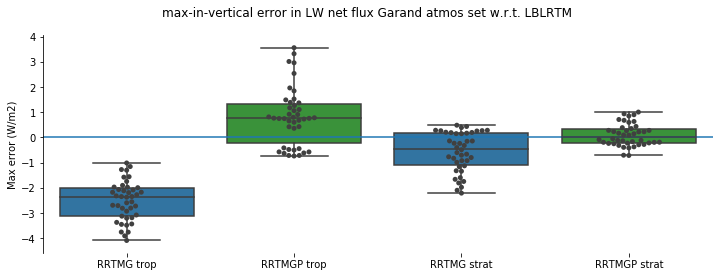

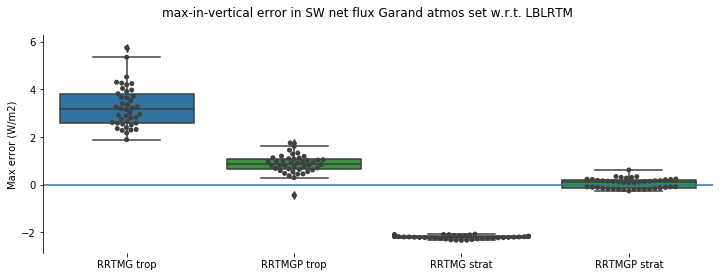

In [19]:
# I'm sure there's an easier way to do this
x, y = plt.rcParams["figure.figsize"]
fig = plt.figure(figsize=(x*2, y)) 
axes = fig.subplots(1,1)
plot_max_vert_err_distribution(axes, "flux_net", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0, 2, 0, 2])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("max-in-vertical error in LW net flux Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-error-net.pdf", dpi=600)

fig = plt.figure(figsize=(x*2, y)) 
axes = fig.subplots(1,1)
plot_max_vert_err_distribution(axes, "flux_net", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0, 2, 0, 2])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("max-in-vertical error in SW net flux Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-error-net.pdf", dpi=600)

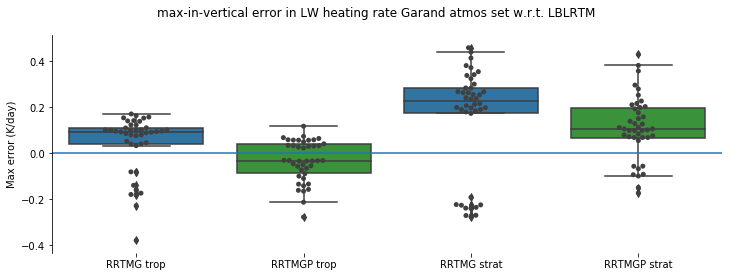

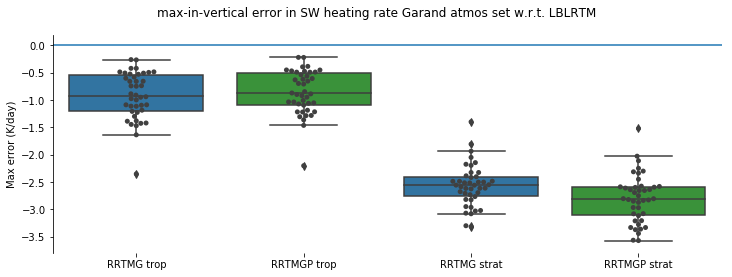

In [17]:
x, y = plt.rcParams["figure.figsize"]
fig = plt.figure(figsize=(x*2, y)) 
axes = fig.add_subplot(111)
plot_max_vert_err_distribution(axes, "heating_rate", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], factor=86400., yaxisunits="K/day", colors = [0, 2, 0, 2])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("max-in-vertical error in LW heating rate Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-error-hr.pdf", dpi=600)

fig = plt.figure(figsize=(x*2, y)) 
axes = fig.add_subplot(111)
plot_max_vert_err_distribution(axes, "heating_rate", sw_charts_file, \
                      [sw_rrtmg_file,  sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], factor=86400., yaxisunits="K/day", colors = [0, 2, 0, 2])
sb.despine()
axes.spines["bottom"].set_visible(False)
fig.suptitle("max-in-vertical error in SW heating rate Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-error-hr.pdf", dpi=600)

In [21]:
rrtmgp = xr.open_dataset(sw_rrtmgp_default_file)
ref = xr.open_dataset(sw_charts_file)
errs = rrtmgp - ref


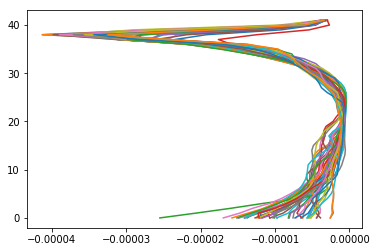

In [30]:
plt.plot(errs.heating_rate, np.arange(42))

In [29]:
errs.heating_rate[:,0] * 86400

<xarray.DataArray 'heating_rate' (lay: 42)>
array([-1.286429, -1.11951 , -0.952586, -0.828741, -0.722437, -0.627382,
       -0.576551, -0.506592, -0.452899, -0.38958 , -0.340164, -0.313782,
       -0.293314, -0.274643, -0.248618, -0.223229, -0.21159 , -0.18288 ,
       -0.137196, -0.098941, -0.074689, -0.058297, -0.048291, -0.04436 ,
       -0.042614, -0.044826, -0.057422, -0.088804, -0.140043, -0.20239 ,
       -0.2984  , -0.440939, -0.6375  , -0.858674, -1.111384, -1.415503,
       -1.849385, -2.681552, -2.850294, -1.365528, -0.459586, -0.285064])
Coordinates:
    col      int32 1
  * lay      (lay) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [31]:
rrtmgp.close()
ref.close()